# MLRW Lecture 2


### Understanding various priors

#### Radial Basis Function

In [459]:
from scipy.spatial.distance import cdist

def rbf_kernel(x1, x2, varSigma, lengthscale):
    if x2 is None:
        d = cdist(x1, x1)
    else:
        d = cdist(x1, x2)
    K = varSigma*np.exp(-np.power(d, 2)/lengthscale)
    return K



#### Linear Kernel

In [460]:
def linear_kernel(x1, x2, varSigma):
    if x2 is None:
        return varSigma*x1.dot(x1.T)
    else:
        return varSigma*x1.dot(x2.T)

#### White Noise Kernel

In [461]:
def white_kernel(x1, x2, varSigma):
    if x2 is None:
        return varSigma*np.eye(x1.shape[0])
    else:
        return np.zeros(x1.shape[0], x2.shape[0])

#### Periodic Kernel

In [462]:
def periodic_kernel(x1, x2, varSigma, period, lengthScale):
    if x2 is None:
        d = cdist(x1, x1)
    else:
        d = cdist(x1, x2)
    return varSigma*np.exp(-(2*np.sin((np.pi/period)*np.sqrt(d))**2)/lengthScale**2)

#### Assessing Kernels

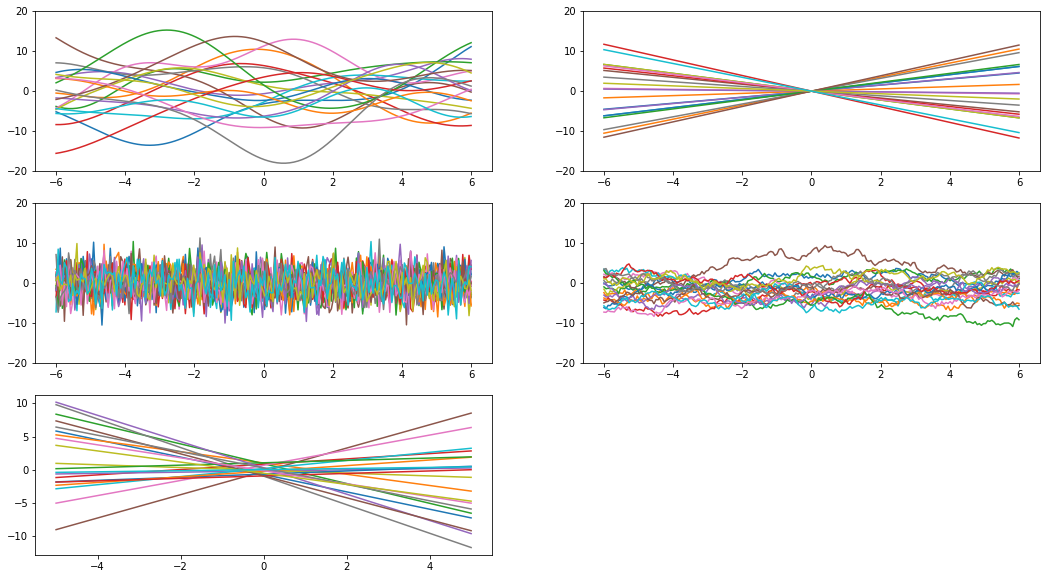

In [464]:
import numpy as np
import matplotlib.pyplot as plt

# choose index set for the marginal
x = np.linspace(-6, 6, 200).reshape(-1, 1)

# create mean vector
mu = np.zeros(x.shape)

# compute covariance matrix
K1 = rbf_kernel(x, None, 30, 10)
K2 = linear_kernel(x, None, 1)
K3 = white_kernel(x, None, 10)
K4 = periodic_kernel(x, None, 10, 10, 1)


fig = plt.figure(figsize=[18, 10])

def plot_prior(fig, mu, K, idx):
    # draw samples 20 from Gaussian distribution
    f = np.random.multivariate_normal(mu.flatten(), K, 20)
    ax = fig.add_subplot(3,2,idx)
    ax.set_ylim([-20,20])
    _ = ax.plot(x, f.T)

plot_prior(fig, mu, K1, 1)
plot_prior(fig, mu, K2, 2)
plot_prior(fig, mu, K3, 3)
plot_prior(fig, mu, K4, 4)

def plot_line(ax, w):
    # input data
    X = np.zeros((2,2))
    X[0,0] = -5.0
    X[1,0] = 5.0
    X[:,1] = 1.0
    # because of the concatenation we have to flip the transpose
    y = w.dot(X.T)
    ax.plot(X[:,0], y)

# Plot prior from linear regression
tau = 1.0*np.eye(2)
w_0 = np.zeros((2,1))

# sample from prior
n_samples = 20
w_samp = np.random.multivariate_normal(w_0.flatten(), tau, size=n_samples)

# create plot
ax = fig.add_subplot(325)
for i in range(0, w_samp.shape[0]):
    plot_line(ax, w_samp[i,:])





#### Assessing Posterior Covariances

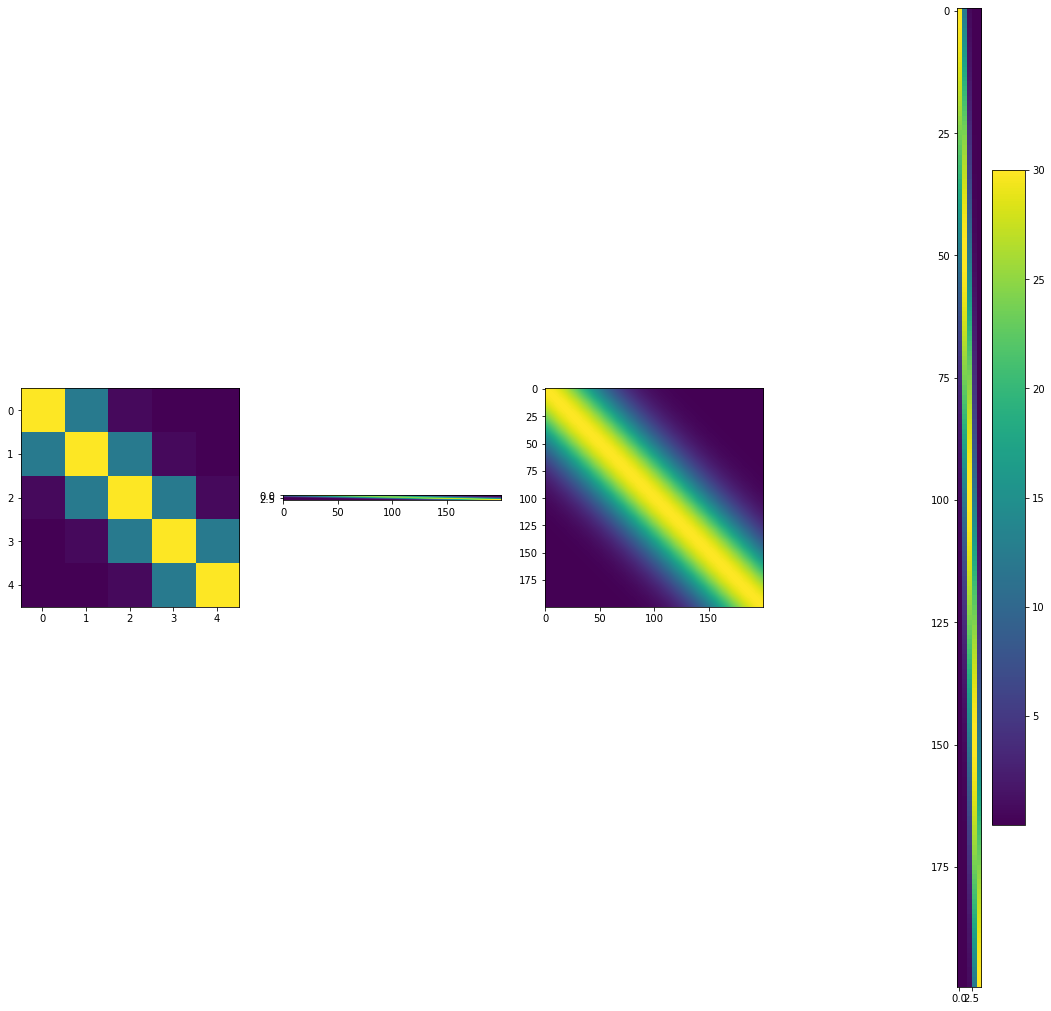

In [465]:
import random

N = 5
x_star = np.matrix(np.linspace(-6,6, 5)).T

k_xstar = rbf_kernel(x_star, None, 30, 10)
k_xstar_x = rbf_kernel(x_star, x, 30, 10)
k_x = rbf_kernel(x, None, 30, 10)
k_x_xstar = rbf_kernel(x, x_star, 30, 10)


fig, ax = plt.subplots(nrows=1, ncols=4, figsize=[18,18])
im1 = ax[0].imshow(k_xstar)
im2 = ax[1].imshow(k_xstar_x)
im3 = ax[2].imshow(k_x)
im4 = ax[3].imshow(k_x_xstar)

_ = fig.colorbar(im4)



#### Combined result

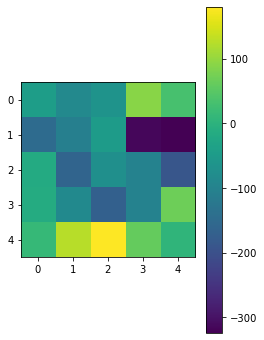

In [466]:
fig = plt.figure(figsize=[18,6])
K_star = k_xstar - np.dot(np.dot(k_xstar_x, np.linalg.inv(k_x)), k_x_xstar)

ax = fig.add_subplot(1,4,1)
_ = ax.imshow(K_star)
_ = fig.colorbar(_)


#### Generate data and sample

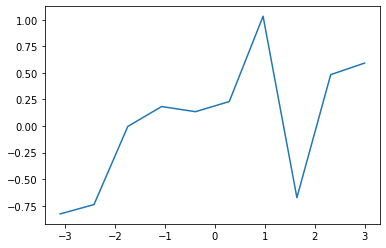

In [558]:
N=10
x = np.linspace(-3.1, 3, N).reshape(-1, 1)
y = np.sin(2*np.pi/x) + x*0.1 + 0.3*np.random.randn(x.shape[0]).reshape(-1,1)
x_star = np.matrix(np.linspace(-6,6, 500)).T

fig = plt.figure()
ax = fig.add_subplot(111)
_=ax.plot(x,y)

In [568]:
def gp_prediction_gaussian(x, y , x_star, lengthScale, varSigma, noise):
    k_xstar = rbf_kernel(x_star, None, varSigma, lengthScale)
    k_xstar_x = rbf_kernel(x_star, x, varSigma, lengthScale)
    k_x = rbf_kernel(x, None, varSigma, lengthScale)
    k_x_xstar = rbf_kernel(x, x_star, varSigma, lengthScale)

    
    mu = np.dot(np.dot(k_xstar_x, np.linalg.inv(k_x)), y)
    var = k_xstar - np.dot(np.dot(k_xstar_x, np.linalg.inv(k_x + noise*np.identity(len(x)))), k_x_xstar)
    
    return mu, var, x_star


def gp_prediction_linear(x, y , x_star, lengthScale, varSigma, noise):
    k_xstar = linear_kernel(x_star, None, varSigma)
    k_xstar_x = linear_kernel(x_star, x, varSigma)
    k_x = linear_kernel(x, None, varSigma)
    k_x_xstar = linear_kernel(x, x_star, varSigma)

    
    mu = np.dot(np.dot(k_xstar_x, np.linalg.inv(k_x)), y)
    var = k_xstar - np.dot(np.dot(k_xstar_x, np.linalg.inv(k_x + noise*np.identity(len(x)))), k_x_xstar)
    
    return mu, var, x_star


def gp_prediction_periodic(x, y , x_star, lengthScale, period, varSigma, noise):
    k_xstar = periodic_kernel(x_star, None, varSigma, period, lengthScale)
    k_xstar_x = periodic_kernel(x_star, x, varSigma, period, lengthScale)
    k_x = periodic_kernel(x, None, varSigma, period, lengthScale)
    k_x_xstar = periodic_kernel(x, x_star, varSigma, period, lengthScale)

    
    mu = np.dot(np.dot(k_xstar_x, np.linalg.inv(k_x)), y)
    var = k_xstar - np.dot(np.dot(k_xstar_x, np.linalg.inv(k_x + noise*np.identity(len(x)))), k_x_xstar)
    
    return mu, var, x_star

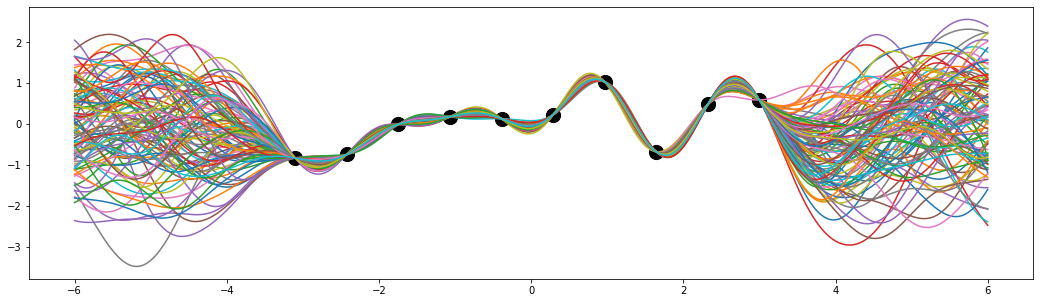

In [576]:
Nsamp = 100
varSigma = 1
lengthScale = 1
noise = 1e-8 # No noise
mu_star, var_star, x_star = gp_prediction_gaussian(x, y, x_star, lengthScale, varSigma, noise)


f_star = np.random.multivariate_normal(np.asarray(mu_star).flatten(), var_star, Nsamp)
fig = plt.figure(figsize=[18,5])
ax = fig.add_subplot(111)
_= ax.plot(x_star, f_star.T)
_= ax.scatter(np.asarray(x).flatten(), np.asarray(y).flatten(), 200, 'k', 'o', zorder=2)

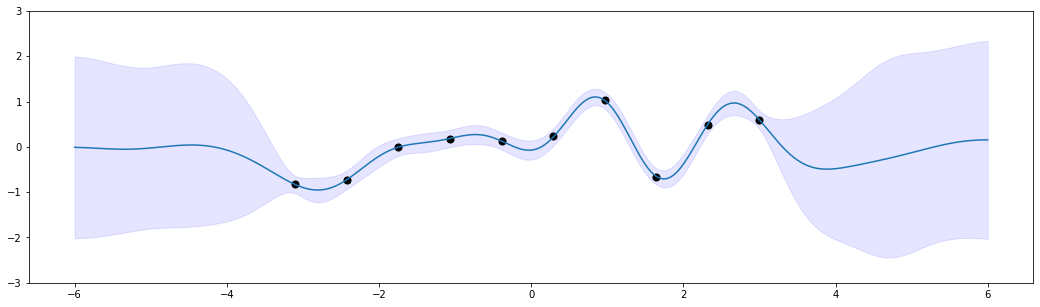

In [565]:
Nsamp = 100
varSigma = 1
lengthScale = 1
noise = 0.01
mu_star, var_star, x_star = gp_prediction_gaussian(x, y, x_star, lengthScale, varSigma, noise)

f_star = np.random.multivariate_normal(np.asarray(mu_star).flatten(), var_star, Nsamp)
fig = plt.figure(figsize=[18,5])
ax = fig.add_subplot(111)
f_star_mean = f_star.mean(0)
ci = 1.96 * f_star.std(0)

_= ax.plot(x_star, f_star_mean)
_= ax.fill_between(np.asarray(x_star).flatten(), (f_star_mean-ci), (f_star_mean+ci), color='b', alpha=.1)
_= ax.scatter(np.asarray(x).flatten(), np.asarray(y).flatten(), 50, 'k', 'o', zorder=2)
_= ax.set_ylim([-3,3])